## Esercizio 12.1

L'obiettivo di questa esercitazione è utilizzare modelli di reti neurali profonde, con l'aiuto della libreria Keras in Python, per identificare correttamente le cifre presenti in immagini contenenti una delle 10 cifre scritte a mano.

Il dataset utilizzato, chiamato MNIST, consiste in un insieme di 70000 cifre scritte a mano rappresentate come matrice di dimensioni 28x28 riempita con valori interi $\in [0,255]$.

Dato che ci sono 10 categorie nel problema, corrispondenti alle 10 cifre da riconoscere, ci troviamo di fronte a un problema di classificazione. L'obiettivo è sviluppare un modello di rete neurale che possa assegnare correttamente ogni immagine alla cifra corrispondente.

Utilizziamo il codice messo a disposizione, ho fatto verie prove e ho ottenuto buoni risultati scegliendo come ottimizzatore "adam" con numero di epoche uguale a 20.

In [12]:
import numpy
import os
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist


In [13]:

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

In [14]:
# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# reshape data, it could depend on Keras backend
#flattening
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) 
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    # mette in modo casuale degli input=0 in modo da evitare overfitting
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    #attivazione è softmax che rende probabilità le dieci componenti
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


In [15]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer="adam",
                  metrics=['acc']) #metrica non obbligatoria
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


In [16]:
# training parameters
batch_size = 32
epochs = 20

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.8591 - loss: 0.4686 - val_acc: 0.9652 - val_loss: 0.1114
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9598 - loss: 0.1399 - val_acc: 0.9727 - val_loss: 0.0888
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9716 - loss: 0.0952 - val_acc: 0.9767 - val_loss: 0.0792
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9794 - loss: 0.0727 - val_acc: 0.9773 - val_loss: 0.0822
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9822 - loss: 0.0585 - val_acc: 0.9783 - val_loss: 0.0851
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9853 - loss: 0.0493 - val_acc: 0.9787 - val_loss: 0.0904
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9873 - loss: 0.0402 - val_acc: 0.9786 - val_loss: 0.0923
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9874 - loss: 0.0395 - val_acc: 0.9746 - val_loss: 0.1186
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - acc: 0.9777 - loss: 0.1559

Test loss: 0.11726491898298264
Test accuracy: 0.9825000166893005


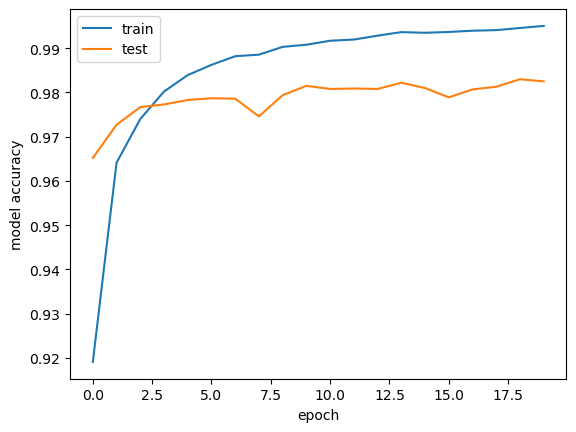

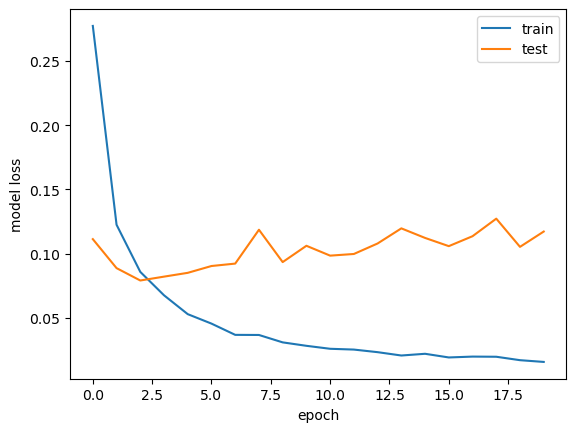

In [17]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Possiamo vedere che l'accuratezza rispetto al set di test si stabilizza intorno alle 10 epoche. Sempre intorno alle 10 epoche invece la funzione di costo inizia ad aumentare, questo potrebbe essere un segnale del fatto che il sistema sta andando in overfitting e che è necessario fermarsi.

In [18]:
predictions = model_DNN.predict(X_test)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


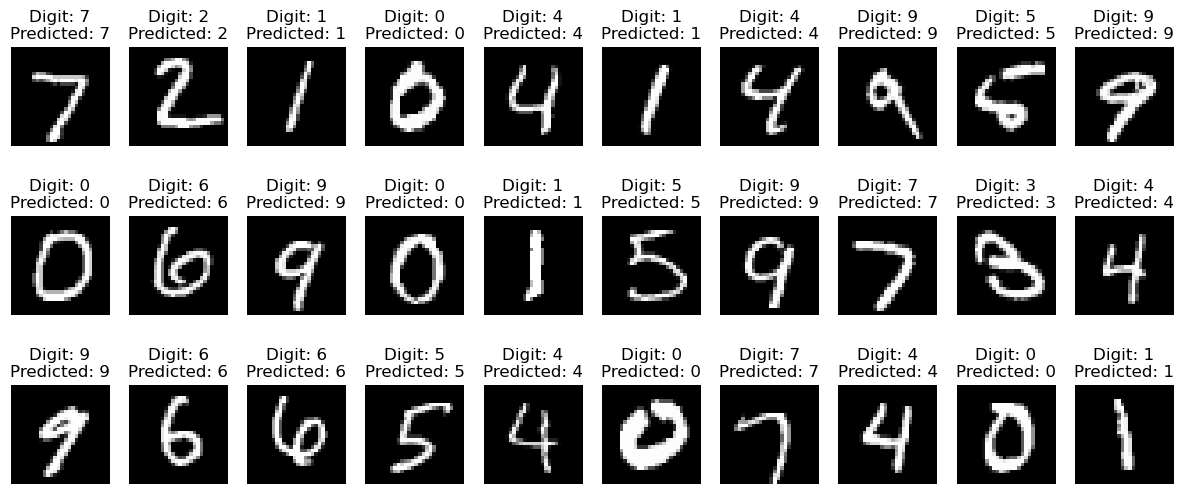

In [19]:
plt.figure(figsize=(15, 15)) 
for i in range(30):    
    ax = plt.subplot(7, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Vediamo le tre file di numeri riconosciute senza problemi.

### Sintesi sugli altri ottimizzatori provati

Ho testato altri ottimizzatori, non riporto tutti i risultati per non appensatire il notebook. Di seguito i risultati ottenuti:

1. sgd: convergenza non velocissima, assolutamente necessarie almeno 20 epoche per ottenere un buon risultato.
2. RMSprop: convergenza più veloce di sgd, già con 10 epoche si ottengono buoni risultati ocn accuratezza intorno al 97.5%. Come per "adam" ad un certo punto la funzione di costo relativa ai dati di test inizia ad aumentare.
3. adam: analizzato precedentemente, buona velocità di convergenza e ottima accuratezza.
4. adadelta: convergenza molto lenta e minore capacità predittiva anche con una ventina di epoche ($\sim 88$%)

## Esercizio 12.2

Considerando ancora le immagini delle cifre scritte a mano presenti nel dataset MNIST, possiamo notare che esistono correlazioni spaziali locali tra i pixel. Finora abbiamo rappresentato i dati del MNIST come vettori 1D di lunghezza 28x28. Tuttavia, potremmo ottenere risultati migliori sfruttando le caratteristiche spaziali, ad esempio prendendo in considerazione le correlazioni tra i pixel e l'invarianza traslazionale durante l'elaborazione delle immagini.

Queste operazioni possono essere fatte utilizzando i convolutional layers in Keras.

Modifichiamo quindi il codice dell'esercizio 12.1, modificando l'architettura della rete attraverso lì'implementazione dei convolutional layers.
Per farlo, mi servirò di layers come:
1. Conv2D: Il layer convoluzionale, basandosi sul layer precedente, produce un'ulteriore layer 2D.
2. Dropout: spegne a caso alcuni neuroni per rendere più difficile l'apprendimento e irrobustire il modello;
3. MaxPooling2D: il layer convoluzionale riduce l'immagine in input selezionando il valore massimo di un pixel all'interno di una finestra di dimensioni fissate.
4. Flatten: appiattisce l'input, facendo passare da 2D a una 1D (a questo punto si strutturare l'architettura con layer di tipo dense)
5. Soft-max: viene applicato alla fine, per fornire output netti.

Alleniamo il modello così strutturato per 20 epoche.

In [26]:
import os
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

In [27]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [28]:
# reshape data, depending on Keras backend
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)

60000 train samples
10000 test samples


In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import Flatten, Conv2D, MaxPooling2D

def create_CNN():
    # instantiate model
    model = Sequential()
    model.add(Conv2D(10, kernel_size=(5, 5),            # add first convolutional layer with 10 filters (dimensionality of output space)
                     activation='relu',
                     input_shape=input_shape))          # Keras SEquential Model can infer the correct input/output dimensions of other layers
    model.add(Dropout(0.5))                             # Dropout, spegne alcuni neuroni, con rate (0.5)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())                                # Moving towards a standard flat layer in the final part
    model.add(Dense(30, activation = 'relu'))
    model.add(Dense(num_classes, activation='softmax')) # Softmax in uscita per un risutlato più netto possibile


    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [30]:
# training parameters
batch_size = 32
epochs = 20

# create the deep conv net
model_CNN=create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# evaliate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20


/home/daniele/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.8634 - loss: 0.4547 - val_acc: 0.9695 - val_loss: 0.1331
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.9685 - loss: 0.1066 - val_acc: 0.9794 - val_loss: 0.0872
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9768 - loss: 0.0764 - val_acc: 0.9826 - val_loss: 0.0702
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9791 - loss: 0.0668 - val_acc: 0.9856 - val_loss: 0.0575
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9831 - loss: 0.0525 - val_acc: 0.9853 - val_loss: 0.0541
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - acc: 0.9851 - loss: 0.0483 - val_acc: 0.9852 - val_loss: 0.0519
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.9862 - loss: 0.0433 - val_acc: 0.9848 - val_loss: 0.0504
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - acc: 0.9876 - loss: 0.0399 - val_acc: 0.9865 - val_loss: 0.0473
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/st

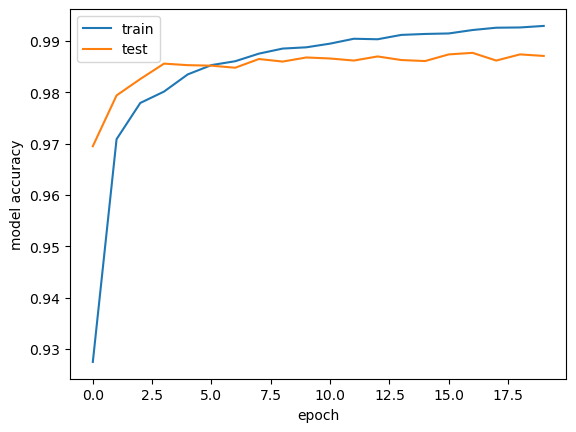

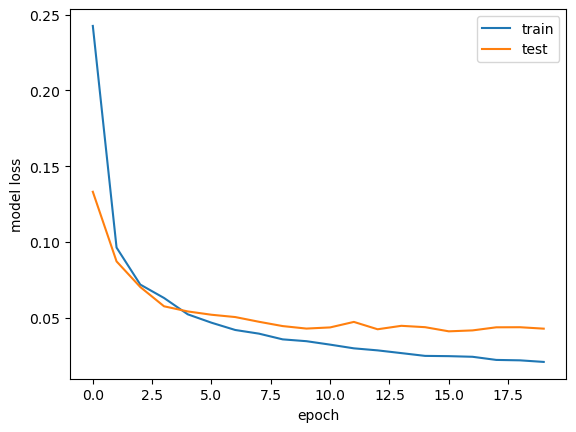

In [31]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [32]:
predictions = model_CNN.predict(X_test)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


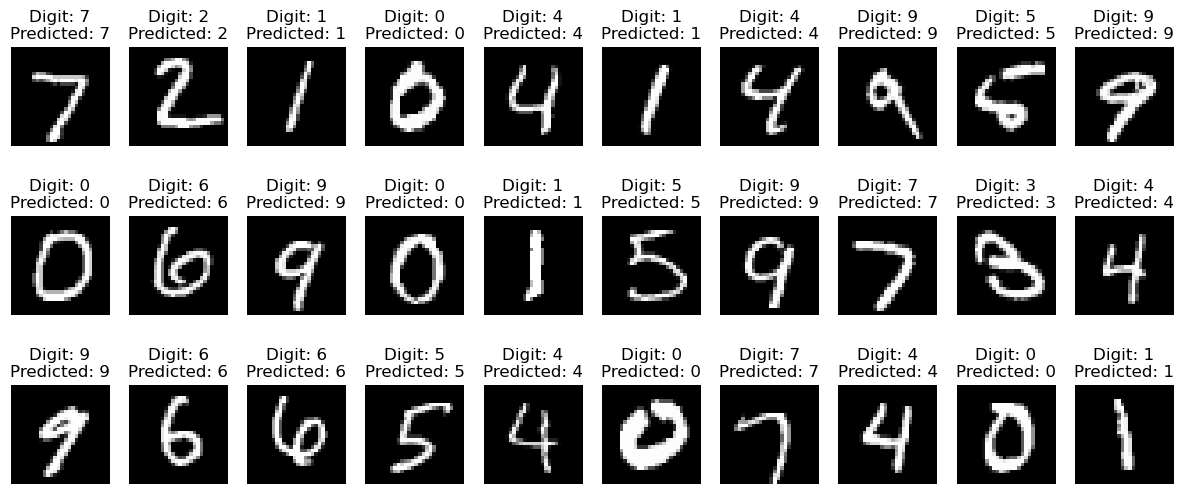

In [33]:
plt.figure(figsize=(15, 15)) 
for i in range(30):    
    ax = plt.subplot(7, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted: {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

Tutte le cifre vengono riconosciute

## Esercizio 12.3

In questa ultima sezione uso la rete neurale appena allenata per riconoscere cifre da me scritte a mano. 

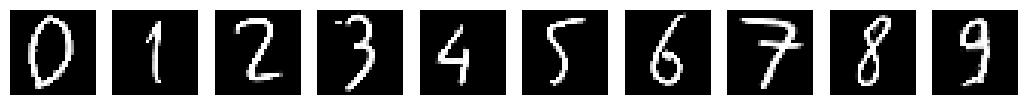

In [34]:
from PIL import Image
import os

data = []
plt.figure(figsize=(13,10))

for l in range(10):
    index = str(l)
    digit_filename = 'numeri/'+index+"_test.png"
    digit_in = Image.open(digit_filename).convert('L')

    ydim, xdim = digit_in.size
    pix=digit_in.load();
    data_back = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data_back[i,j]=pix[j,i]/255
    data.append(data_back)

    ax = plt.subplot(6, 10, l + 1)
    plt.imshow(data[l], cmap='gray')
    plt.axis('off')
plt.show()

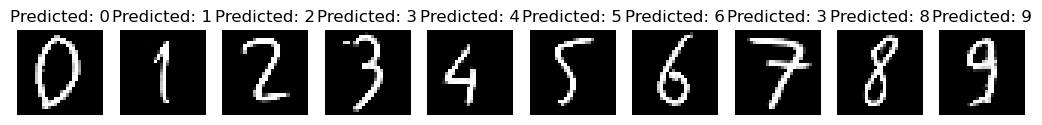

In [35]:
plt.figure(figsize=(13,10))

for l in range(10):
    data1 = data[l].reshape(1, xdim, ydim, 1)  # Reshape to match CNN input shapeprint(data.shape)
    pred_0 = model_CNN.predict(data1, verbose=0)

    data1 = data1.reshape(xdim,ydim)


    ax = plt.subplot(3, 10, l + 1)
    plt.imshow(data1, cmap='gray')    
    plt.title("Predicted: {}".format(np.argmax(pred_0)))
    plt.axis('off') 
    
plt.show()

La rete ha riconosciuto nove cifre su dieci. Il risultato può essere ritenuto buono perché il 7, per quanto possa sembrare scritto bene, è piuttosto diverso dai 7 presenti in MINST che non presentano la stanghetta a metà.